# Wealth-in-Utility Multiplicatively with Consumption

The typical consumption-saving model assumes that agents derive a flow of utility from consumption each period, with additively separable utility across time. In `HARK.ConsumptionSaving.ConsWealthUtility` module, we change this assumption to allow wealth (end-of-period assets) to enter the agent's utility function directly.

This notebook concerns agents whose direct preferences for wealth are represented *multiplicatively* with consumption under a Cobb-Douglas aggregator. For *additive* direct preferences for wealth, see [the notebook for `CapitalistSpiritConsumerType`](./CapitalistSpiritConsumerType.ipynb) in the same module.

In [1]:
# Import basic packages and the AgentType subclass of interest
import matplotlib.pyplot as plt
from HARK.utilities import plot_funcs
from time import time

from HARK.ConsumptionSaving.ConsWealthUtilityModel import (
    WealthUtilityConsumerType,
    init_wealth_utility,
)
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType  # comparitor


def mystr(x):
    return "{:.4f}".format(x)

## Multiplicative Wealth-in-Utility Consumption-Saving Model Statement

A `WealthUtilityConsumerType`'s problem can be expressed as:

$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\CRRA}{\rho}$
$\newcommand{\LivPrb}{\mathsf{S}}$
$\newcommand{\PermGroFac}{\Gamma}$
$\newcommand{\Rfree}{\mathsf{R}}$
$\newcommand{\DiscFac}{\beta}$
$\newcommand{\WealthShare}{\alpha}$
$\newcommand{\WealthShift}{\xi}$
$\newcommand{\cNrm}{c}$
$\newcommand{\mNrm}{m}$
$\newcommand{\aNrm}{a}$

\begin{equation*}
        v_t(m_t) = \max_{c_t}u(x_t) + \DiscFac \LivPrb_{t} \mathbb{E}_{t} \left[ (\PermGroFac_{t+1} \psi_{t+1})^{1-\CRRA} v_{t+1}(m_{t+1}) \right] ~~\text{s.t.}
\end{equation*}
\begin{eqnarray*}
        u(x) &=& \frac{x^{1-\CRRA}}{1-\CRRA}, \\
        x_t &=& (a_t + \WealthShift)^\WealthShare c_t^{1-\WealthShare}, \\
        a_t &=& m_t - c_t, \\
        a_t &\geq& \underline{a}, \\
        m_{t+1} &=& a_t \Rfree_{t+1}/(\PermGroFac_{t+1} \psi_{t+1}) + \theta_{t+1}, \\
        (\psi_{t+1},\theta_{t+1}) &\sim& F_{t+1}, \\
        \mathbb{E}[\psi] &=& 1. \\
\end{eqnarray*}

This model is identical to that of an `IndShockConsumerType` but for the presence of the Cobb-Douglas combination of assets and consumption to yield "effective consumption" $x_t$. As such, this model degenerates to `IndShockConsumerType` as $\WealthShare \rightarrow 0$.

Note that the shifter term $\WealthShift$ (denoted `WealthShift` in the model code) does not have a consistent interpretation in this normalized framework. That is, if $\WealthShift > 0$, then the model above cannot be "de-normalized" to express preferences strictly in terms of *levels* of consumption and wealth. The model can still be solved when `WealthShift` is not zero, but the parameter will not control the extent to which wealth accumulation is a luxury good *in levels*.

**NB:** The HARK team will soon add a non-normalized version of this model to allow $\WealthShift > 0$ to be interpreted consistently in levels.

## Solving the Multiplicative Wealth-in-Utility Model

(This section is adapted from Appendix A.3 of "Life-Cycle Modeling is Ready for Prime Time", which Matt White wrote.)

In the standard consumption-saving model with CRRA utility over consumption only, the first order condition w.r.t consumption is trivial to invert; this is not the case when consumption and wealth are multiplicatively combined into a single term in the CRRA function. To start, we substitute the Cobb-Douglas aggregator into the CRRA utility function:

\begin{align}
    u(\cNrm, \aNrm) & = \frac{\left(\cNrm^{1-\WealthShare}(\aNrm+\WealthShift)^{\WealthShare}\right)^{1-\CRRA}}{1-\CRRA} = \frac{\left(\cNrm^{1-\WealthShare}(\mNrm - \cNrm + \WealthShift)^{\WealthShare}\right)^{1-\CRRA}}{1-\CRRA}.
\end{align}

Fixing market resources $\mNrm$ at some value of interest, the marginal return to utility from consumption is:

\begin{align*}
\frac{\text{d}}{\text{d} \cNrm} u(\cNrm, \mNrm-\cNrm) &= \left[ (1-\WealthShare) \cNrm^{-\WealthShare} (\mNrm - \cNrm + \WealthShift)^\WealthShare - \WealthShare \cNrm^{1-\WealthShare}(\mNrm - \cNrm + \WealthShift)^{\WealthShare-1} \right] \cdot \left( (\mNrm - \cNrm + \WealthShift)^\WealthShare \cNrm^{1-\WealthShare}  \right)^{-\CRRA} \\
 &= \left[ (1-\WealthShare) \left(\frac{\cNrm}{\mNrm-\cNrm + \WealthShift}\right)^{-\WealthShare} - \WealthShare \left(\frac{\cNrm}{\mNrm - \cNrm + \WealthShift} \right)^{1-\WealthShare} \right] \cdot \left( (\mNrm - \cNrm + \WealthShift)^\WealthShare \cNrm^{1-\WealthShare}  \right)^{-\CRRA} \\
 &= \left[ (1-\WealthShare) \left(\frac{\cNrm}{\aNrm + \WealthShift}\right)^{-\WealthShare} - \WealthShare \left(\frac{\cNrm}{\aNrm + \WealthShift} \right)^{1-\WealthShare} \right] \cdot \left( (\aNrm + \WealthShift) (\aNrm + \WealthShift)^{\WealthShare-1} \cNrm^{1-\WealthShare}  \right)^{-\CRRA} \\
 &= \left[ (1-\WealthShare) \chi^{-\WealthShare} - \WealthShare \chi^{1-\WealthShare} \right] \cdot \left( (\aNrm + \WealthShift) \chi^{1-\WealthShare}  \right)^{-\CRRA}, ~~~~ \chi \equiv \frac{\cNrm}{\aNrm + \WealthShift}.
\end{align*}

These algebraic manipulations will prove useful when we solve the first order condition momentarily. With wealth-in-utility preferences, the agent's optimal consumption problem is:

\begin{align*}
v_t(\mNrm_t) &= \max_\cNrm \left[ u(\cNrm, \mNrm_t-\cNrm) + \mathfrak{v}_t(\mNrm_t - \cNrm) \right].
\end{align*}

In this equation, we have already expressed the continuation or end-of-period value function over assets $a_t$ in EGM form (see [here](../Gentle-Intro/Methods-Intro.ipynb)), denoted as $\mathfrak{v}_t(a_t)$.

Consider the first order condition for optimality by taking the derivative of the maximand with respect to $\cNrm$ and equating it to zero:

\begin{equation}
\frac{\text{d}}{\text{d} \cNrm} u(\cNrm_t, \mNrm_t-\cNrm_t) - \mathfrak{v}'_t(\mNrm_t - \cNrm_t) = 0.
\end{equation}

We can substitute the final form of the marginal return to consumption, move the second term to the right-hand side, and then rearrange slightly to get:

\begin{equation*}
\left[ (1-\WealthShare) \chi_t^{-\WealthShare} - \WealthShare \chi_t^{1-\WealthShare} \right] \cdot \left( (\aNrm_t + \WealthShift) \chi_t^{1-\WealthShare}  \right)^{-\CRRA} = \mathfrak{v}'_t(\aNrm_t) \Longrightarrow
\end{equation*}
\begin{equation*}
\left[ (1-\WealthShare) \chi_t^{-\WealthShare} - \WealthShare \chi_t^{1-\WealthShare} \right]^{-1/\CRRA} \cdot \chi_t^{1-\WealthShare}  = \underbrace{\mathfrak{v}'_t(\aNrm_t)^{-1/\CRRA} / (\aNrm_t + \WealthShift)}_{\equiv ~ \omega_t}.
\end{equation*}

The left-hand side of the rearranged FOC is monotonically increasing with respect to $\chi = \cNrm/(\aNrm+\WealthShift) > 0$, starting from zero and growing without bound. Moreover, the RHS (which uses \textit{only} information about the continuation value through $\aNrm_t$) must be strictly positive, as both marginal value and end-of-period assets are strictly positive (the consumer will never choose $\aNrm \leq -\WealthShift$ with these preferences because it would yield infinitely negative utility). Hence the first order condition has a unique solution in $\chi_t$ for each $\aNrm_t$.

Unfortunately, there is no closed form solution for the rearranged FOC to recover $\chi_t$ from $\omega_t$. While it would be possible to use a rootfinder to solve it for each value of $\omega_t$ as it comes up during the solution process, it is more efficient to pre-compute a function that accurately maps from $\omega$ to $\chi$. We now describe a method for constructing such a function by working with the inverse relationship.

First, note that the expression in square brackets is not positive for all values of $\chi > 0$, with the bounding condition defined by:

\begin{equation*}
(1-\WealthShare) \chi^{-\WealthShare} - \WealthShare \chi^{1-\WealthShare} > 0 \Longrightarrow (1-\WealthShare) \chi^{-\WealthShare} > \WealthShare \chi^{1-\WealthShare} \Longrightarrow \frac{1-\WealthShare}{\WealthShare} >\chi.
\end{equation*}

The expression in square brackets is raised to a negative power, hence we need only to consider values of $\chi \in (0, (1 -\WealthShare)/\WealthShare)$. These $\chi$ values represent the *range* of the function that maps from $\omega$ to $\chi$, and we want our constructed approximation to cover as much of that range as possible. To do so, we will use the logit transformation to map from an auxiliary variable $z \in \R$ to $\chi \in (0, (1 -\WealthShare)/\WealthShare)$:

\begin{equation*}
\chi = \frac{\exp(z)}{1 + \exp(z)} \cdot \frac{1-\WealthShare}{\WealthShare}.
\end{equation*}

The domain of the function we want to approximate is $\omega > 0$ or $\omega \in \R_{++}$, so we can work with $\log(\omega)$ to ensure that we are working with strictly positive numbers. To approximate the mapping from $\omega$ to $\chi$:

1. Fix a grid of $z$ values centered around zero; we use a uniformly spaced grid with 301 gridpoints between $\pm 15$.

2. For each $z$ in the grid, calculate the corresponding $\chi$ using the logit transform. With our $z$ grid, this spans the inner 99.99994\% of the feasible range of $\chi$.

3. For each $\chi$ in that grid, calculate $\omega$ using the rearranged FOC, then compute $\log(\omega)$.

4. Construct a linear spline interpolant that maps from the vector of $\log(\omega)$ values to the grid of $z$, with linear extrapolation above and below; call this function $g(\cdot)$.

5. Define function $f(\cdot)$ as the composition of the logit transform, $g$, and $\log$.

By construction, $f$ is an approximation of the mapping from $\omega$ to $\chi$ implicitly defined by the FOC, by successively applying the logarithm to $\omega$, the interpolant from $\log(\omega)$ to $z$, and the logit transformation to recover $\chi$. The approximation is extremely accurate, even on the extrapolated region on $\omega$, because the underlying mapping from $\log(\omega)$ to $z$ approaches linearity on both ends. Conveniently, the $f$ function depends on only $\CRRA$ and $\WealthShare$ and can be constructed once for all periods of the life-cycle.

In the HARK code, the $f$ function is represented by an instance of the class `ChiFromOmegaFunction`, which is built by the constructor function `make_ChiFromOmega_function`.

With the mapping $f : \omega \rightarrow \chi$ in hand, we can now describe our algorithm for solving for optimal consumption under wealth-in-utility preferences:

1. Fix an exogenous grid of $\aNrm_t$ values from the natural borrowing constraint to a large value (say, a wealth-to-income ratio of 100).

2. For each $\aNrm$ in the grid, evaluate $\mathfrak{v}'_t(\aNrm_t)$, then raise it to the $-1/\CRRA$ power and divide by $(\aNrm + \WealthShift)$, yielding a vector of $\omega$ values.

3. For each $\omega$ in that vector, compute $\chi = f(\omega)$, then multiply by $(\aNrm + \WealthShift)$ to recover the optimal $\cNrm$.

4. Find the associated decision-time state by inverting the intraperiod budget: $\mNrm_t = \aNrm_t + \cNrm_t$.

5. Construct the consumption function as a linear interpolant over those $(\mNrm_t, \cNrm_t)$ pairs, adding a point at $c_t=0$ corresponding to the natural borrowing constraint.

6. Construct the marginal value function $v'_t(\mNrm_t)$ as the composition of the marginal utility function and the consumption function.

As a final note, the natural borrowing constraint in the wealth-in-utility is the *more* restrictive of the usual natural borrowing constraint (the lowest value of $\aNrm_t$ such that a valid $\mNrm_{t+1}$ value is reached no matter which income shocks realize) and $-\WealthShift$. As mentioned above, utility flow goes to negative infinity (or at least marginal utility goes to positive infinity) as $\aNrm_t \rightarrow -\WealthShift$ because of the Cobb-Douglas aggregator. Thus the agent will *never* choose to end the period with $\aNrm_t \leq -\WealthShift$, so the natural borrowing constraint can be no lower than this level.

In the typical case with $\WealthShift = 0$ in the permanent-income-normalized model, the agents will never borrow at all, even without an artificial liquidity constraint.

## Example parameter values to construct a `WealthUtilityConsumerType`

The `WealthUtilityConsumerType` builds off of `IndShockConsumerType`, so the set of parameters that specify an instance (with default constructors) is very similar to the base class. The table below presents the complete list of parameters for `WealthUtilityConsumerType`, along with example values.

| Parameter | Description | Code | Example value | Time-varying? |
| :---: | --- | --- | --- | --- |
| $\DiscFac$ |Intertemporal discount factor  | `DiscFac` | $0.96$ |  |
| $\CRRA$ |Coefficient of relative risk aversion | `CRRA` | $2.0$ | |
| $\WealthShare$ | Share of wealth in Cobb-Douglas combination | `WealthShare` | $0.2$ | |
| $\WealthShift$ | Additive shifter for wealth in Cobb-Douglas combination | `WealthShift` | $0.0$ | |
| $\Rfree_t$ | Risk free interest factor | `Rfree` | $[1.03]$ | $\surd$ |
| $\LivPrb_t$ |Survival probability | `LivPrb` | $[0.98]$ | $\surd$ |
|$\PermGroFac_{t+1}$|Permanent income growth factor| `PermGroFac` | $[1.01]$ | $\surd$ |
| $\sigma_\psi$| Standard deviation of log permanent income shocks | `PermShkStd` | $[0.1]$ |$\surd$ |
| $N_\psi$| Number of discrete permanent income shocks | `PermShkCount` | $7$ | |
| $\sigma_\theta$| Standard deviation of log transitory income shocks | `TranShkStd` | $[0.2]$ | $\surd$ |
| $N_\theta$| Number of discrete transitory income shocks | `TranShkCount` | $7$ |  |
| $\mho$ | Probability of being unemployed and getting $\theta=\underline{\theta}$ | `UnempPrb` | $0.05$ |  |
| $\underline{\theta}$| Transitory shock when unemployed | `IncUnemp` | $0.3$ |  |
| $\mho^{Ret}$ | Probability of being "unemployed" when retired | `UnempPrbRet` | $0.0005$ |  |
| $\underline{\theta}^{Ret}$| Transitory shock when "unemployed" and retired | `IncUnempRet` | $0.0$ |  |
| $(none)$ | Period of the lifecycle model when retirement begins | `T_retire` | $0$ | |
| $(none)$ | Minimum value in assets-above-minimum grid | `aXtraMin` | $0.001$ | |
| $(none)$ | Maximum value in assets-above-minimum grid | `aXtraMax` | $20.0$ | |
| $(none)$ | Number of points in base assets-above-minimum grid | `aXtraCount` | $48$ | |
| $(none)$ | Exponential nesting factor for base assets-above-minimum grid | `aXtraNestFac` | $3$ | |
| $(none)$ | Additional values to add to assets-above-minimum grid | `aXtraExtra` | $None$ | |
| $\underline{a}$| Artificial borrowing constraint (normalized) | `BoroCnstArt` | $0.0$ | |
| $(none)$|Indicator for whether `vFunc` should be computed | `vFuncBool` | $True$ | |
| $(none)$ |Indicator for whether `cFunc` should use cubic splines | `CubicBool` | $False$ |  |
|$T$| Number of periods in this type's "cycle" | `T_cycle` | $1$ | |
|(none)| Number of times the "cycle" occurs | `cycles` | $0$ | |

## Example Implementations of `WealthUtilityConsumerType`

The `WealthUtilityConsumerType` has workable defaults, so let's begin with those, solving an infinite horizon problem right off the shelf. At the default parameters, `WealthShare` is $0.2$ and `WealthShift` is $0.0$.

In [2]:
# Make an infinite horizon wealth-in-utility consumer type with default parameters
WIUtype = WealthUtilityConsumerType(cycles=0)

In [3]:
# Solve the wealth-in-utility model
t0 = time()
WIUtype.solve()
t1 = time()
print(
    "Solving an infinite horizon wealth-in-utility consumption-saving problem took "
    + mystr(t1 - t0)
    + " seconds."
)

Solving an infinite horizon wealth-in-utility consumption-saving problem took 0.1070 seconds.


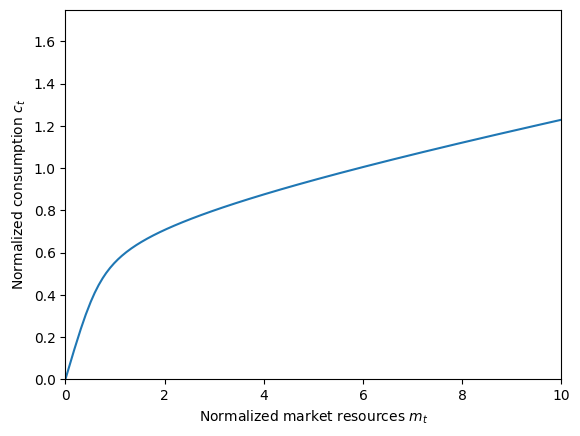

In [4]:
# Plot the consumption function
WIUtype.unpack("cFunc")
plt.ylim(0.0, 1.75)
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plot_funcs(WIUtype.cFunc, 0.0, 10.0)

The consumption function for a `WealthUtilityConsumerType` will always be strictly less than the corresponding `IndShockConsumerType`, as long as `WealthShare` is positive. To see an example of this, let's make an `IndShockConsumerType` with the same parameters as a default `WealthUtilityConsumerType` and compare their solutions.

In [5]:
# Make a basic consumer representation using the default parameters for the wealth-in-utility model
BaseType = IndShockConsumerType(**init_wealth_utility)
BaseType.assign_parameters(cycles=0)

In [6]:
# Solve the infinite horizon consumption-saving model for the standard model
t0 = time()
BaseType.solve()
t1 = time()
print(
    "Solving an infinite horizon standard consumption-saving problem took "
    + mystr(t1 - t0)
    + " seconds."
)

Solving an infinite horizon standard consumption-saving problem took 0.1020 seconds.


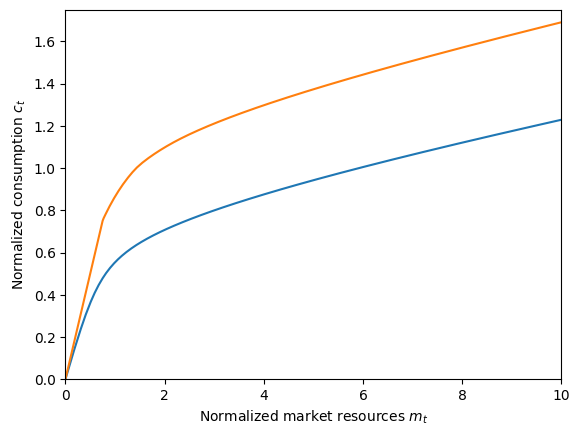

In [7]:
# Plot the consumption function for both types on the same figure
BaseType.unpack("cFunc")
plt.ylim(0.0, 1.75)
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plot_funcs([WIUtype.cFunc[0], BaseType.cFunc[0]], 0.0, 10.0)

This graph illuminates one of the key features of the wealth-in-utility model: even though the agent is guaranteed to have strictly positive income in $t+1$, they *never* want to end the period with $a_t=0$, because this would yield infinitely negative utility. That is, the artificial borrowing constraint $a_t \geq 0$ *doesn't bind*.

To have the artificial borrowing constraint bind at low levels of $m_t$, we can set $\WealthShift > 0$ so that the agent *is* willing to go as low as $a_t = -\WealthShift$ (but they'll be prevented by the artificial borrowing constraint).

In [8]:
# Make the artificial borrowing constraint bind in the wealth-in-utility model
ConstrainedType = WealthUtilityConsumerType(cycles=0, WealthShift=4.0)
ConstrainedType.solve()

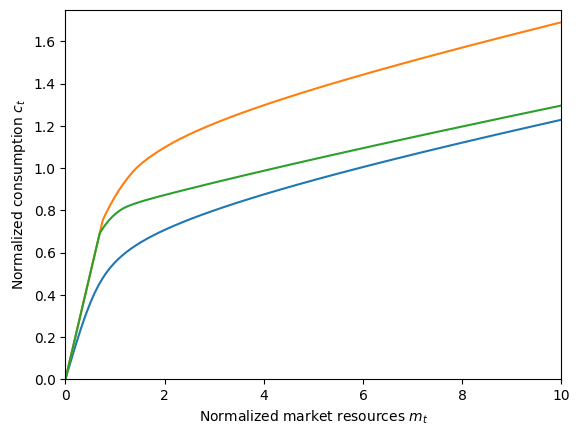

In [9]:
# Plot all three consumption functions for comparison
ConstrainedType.unpack("cFunc")
plt.ylim(0.0, 1.75)
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plot_funcs([WIUtype.cFunc[0], BaseType.cFunc[0], ConstrainedType.cFunc[0]], 0.0, 10.0)

It's not obvious from this figure, but the green consumption (with positive `WealthShift`) asymptotes to the blue consumption function (with zero `WealthShift`) as wealth becomes arbitrarily large.

Finally, recall that the wealth-in-utility model degenerates to the basic consumption-saving model when $\WealthShare=0$. To (visually) confirm this, let's solve a `WealthUtilityConsumerType` with `WealthShare=0` and compare it to the basic model.

In [10]:
# Make and solve a wealth-in-utility consumer type that doesn't actually care about wealth
TrivialType = WealthUtilityConsumerType(cycles=0, WealthShare=0.0)
TrivialType.solve()
TrivialType.unpack("cFunc")

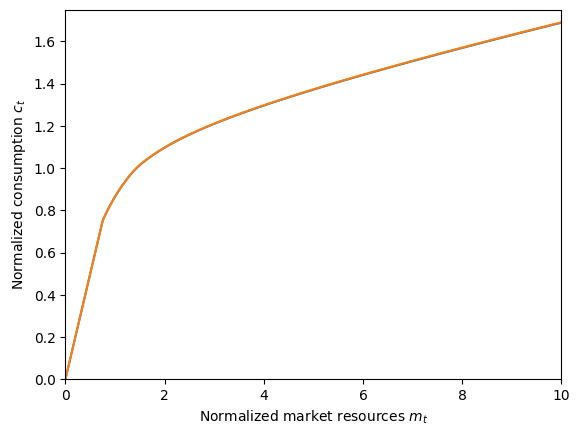

In [11]:
# Plot what should be identical consumption functions
plt.ylim(0.0, 1.75)
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plot_funcs([TrivialType.cFunc[0], BaseType.cFunc[0]], 0.0, 10.0)

Looks the same to me!